In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import transformers
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.optim import Adam, SGD
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import torch.nn as nn
from tqdm import tqdm

In [3]:
dataset_path = "/content/drive/MyDrive/bd calling/train.csv"  # Ensure the correct path
data = pd.read_csv(dataset_path)

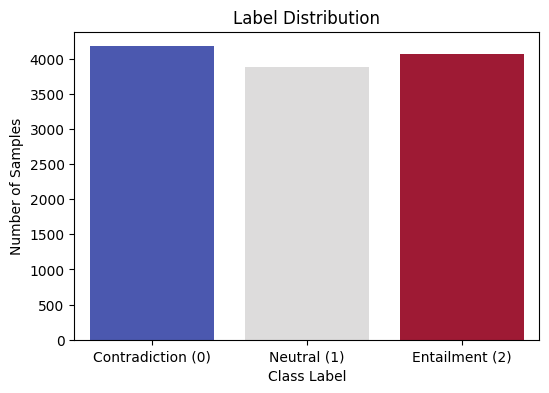

In [4]:
plt.figure(figsize=(6, 4))
sns.countplot(x=data['label'], hue=data['label'], palette='coolwarm', legend=False)
plt.xticks(ticks=[0, 1, 2], labels=['Contradiction (0)', 'Neutral (1)', 'Entailment (2)'])
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Label Distribution")
plt.show()

In [5]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)  # Remove special characters
    return text

# Apply cleaning
data['clean_premise'] = data['premise'].apply(clean_text)
data['clean_hypothesis'] = data['hypothesis'].apply(clean_text)
data['combined_text'] = data['clean_premise'] + " " + data['clean_hypothesis']

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [7]:
class SentenceDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data['combined_text'].tolist(), data['label'].tolist(), test_size=0.2, random_state=42)
train_dataset = SentenceDataset(X_train, y_train, tokenizer)
test_dataset = SentenceDataset(X_test, y_test, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [9]:
class CustomBERTModel(nn.Module):
    def __init__(self):
        super(CustomBERTModel, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
        self.dropout = nn.Dropout(0.3)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask, return_dict=True)
        return outputs.logits

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
model = CustomBERTModel().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=1e-2)
loss_fn = torch.nn.CrossEntropyLoss()
scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=len(train_loader) * 30)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
def train_model(model, train_loader, optimizer, loss_fn, scheduler, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            progress_bar.set_postfix(loss=total_loss / len(train_loader), accuracy=correct/total)

# Train the model
train_model(model, train_loader, optimizer, loss_fn, scheduler, epochs=10)

Epoch 10/10: 100%|██████████| 606/606 [03:37<00:00,  2.78it/s, accuracy=0.878, loss=0.216]


In [20]:
def evaluate_model(model, test_loader):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs, dim=1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    return true_labels, predictions

true_labels, predictions = evaluate_model(model, test_loader)

Model Accuracy: 0.5375412541254125
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.71      0.60       851
           1       0.53      0.40      0.46       773
           2       0.58      0.48      0.53       800

    accuracy                           0.54      2424
   macro avg       0.54      0.53      0.53      2424
weighted avg       0.54      0.54      0.53      2424



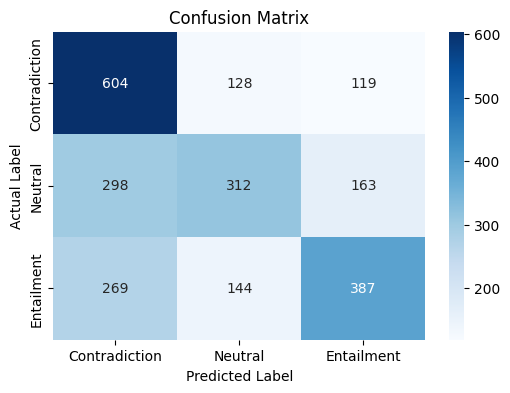

In [21]:
print("Model Accuracy:", accuracy_score(true_labels, predictions))
print("Classification Report:\n", classification_report(true_labels, predictions))

# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(true_labels, predictions), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Contradiction', 'Neutral', 'Entailment'],
            yticklabels=['Contradiction', 'Neutral', 'Entailment'])
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()